# Imputing Fare

In [3]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Note4:
Pclass is obviously a great variable to estimate fare. This time, ticket can actually help predicting the fare. But the pattern of ticket numbering should be known. Cabin number can also help as fare can vary depending upon quality of cabin. I can not use age as I have already used fare to estimate age. Also embarked port can help here.

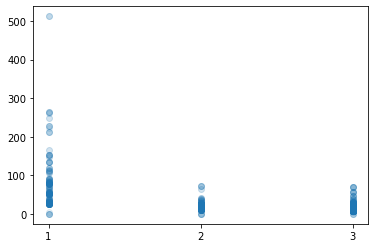

In [6]:
# start by looking at pclass
plt.scatter(data.Pclass, data.Fare, alpha=0.1)
_ = plt.xticks([1, 2, 3])

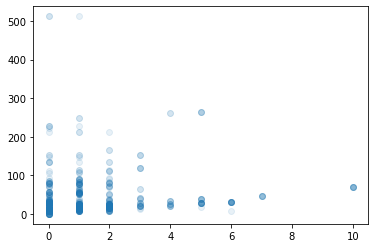

In [44]:
data['fam_n_frnd'] = data.SibSp + data.Parch

plt.scatter('fam_n_frnd', 'Fare', data=data, alpha=0.1)

In [9]:
sum(data.Fare > 450)

3

In [11]:
print(f'unique tickets = {data.Ticket.unique().shape}\nunique fares = {data.Fare.unique().shape}')

unique tickets = (681,)
unique fares = (248,)


([<matplotlib.axis.YTick at 0x2599cb183c8>,
 <a list of 3 Text major ticklabel objects>)

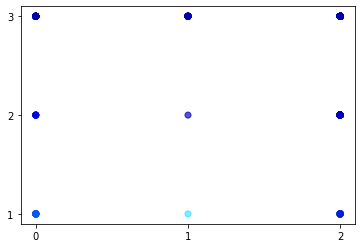

In [34]:
plt.scatter(x='Embarked', y='Pclass', data=data[~data.Embarked.isnull()], alpha=0.3,
            c='Fare', cmap=plt.get_cmap('jet'))
plt.xticks([0.0, 1.0, 2.0])
plt.yticks([1.0, 2.0, 3.0])


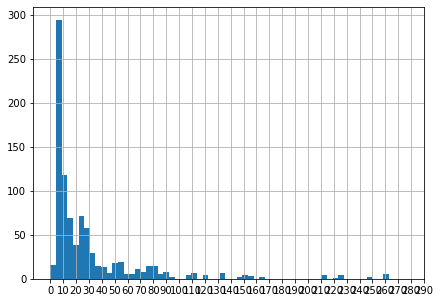

In [42]:
plt.subplots(figsize=(7,5))
data[data.Fare < 400].Fare.hist(bins=60)
_ = plt.xticks(np.arange(0, 300, step=20))

# (0, 10), (10, 30), (30, 100), (100, 200), (200,)

In [36]:
sum(data.Embarked.isnull())

2

In [13]:
#create a function to name data frames

namedict = {'Pclass': ['1', '2', '3'], 
            'Sex': ['female', 'male'],
            'Cabin': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'],
            'Embarked': ['C', 'Q', 'S'],
            'Age': '',
            'SibSp': '',
            'Parch': '',
            'Fare': '',
            }

def col_names(features=[], extra = []):
    namelist = []
    for feature in features:
        for category in namedict[feature]:
            namelist.append(feature + '_' + category)
    namelist.extend(extra)
    return namelist

### Load clean data and fit model

In [36]:
Pclass_ix = np.s_[:, 0:3]
Sex_ix = np.s_[:, 3:5]
Cabin_ix = np.s_[:, 5:14]
Embarked_ix = np.s_[:, 14:17]
Age_ix = np.s_[:, 17]
SibSp_ix = np.s_[:, 18]
Parch_ix = np.s_[:, 19]
Fare_ix = np.s_[:, 20]

clean_data = pd.read_csv(data_dir + 'halfclean.csv', index_col=0).to_numpy()
X = np.c_[clean_data[Pclass_ix], clean_data[Sex_ix], clean_data[Cabin_ix],
            clean_data[Embarked_ix], clean_data[SibSp_ix] + clean_data[Parch_ix]]

X = pd.DataFrame(X)
X.columns = col_names(features=['Pclass', 'Sex', 'Cabin', 'Embarked'], extra=['fam_n_frnd'])
y = clean_data[Fare_ix]

In [37]:
#train model
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_estimators': np.arange(30, 130, step=20),
     'max_depth': [2, 3],
     'max_leaf_nodes': [3, 4, 5]
    },
]

xgb = XGBClassifier()

grids = GridSearchCV(xgb, param_grid, scoring="f1_macro", return_train_score=True, cv=5)
grids.fit(X, y)

joblib.dump(grids.best_estimator_, 'filename.pkl')
grids.best_params_

{'max_depth': 3, 'max_leaf_nodes': 3, 'n_estimators': 30}

0.542010162475504


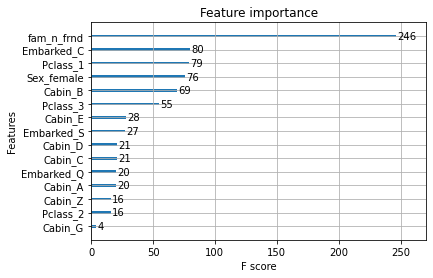

In [38]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)

### Note5:
obviously xgboost is not performing well. Let's try knn. But first of all I need to create Pipline to clean the data.

## Pipline to clean data

### Note6: 
Right now we will not use the name column and ticket column.
The final pipeline should look like this

Drop Name, Ticket + add fam_n_frnd ;; Impute, categorize Cabin and Embarked <br>
-- One hot encode Cabin, Embarked, Sex, Pclass <br>
-- Create ordinal fare group <br>
-- impute Age <br>
====== thus cleaning is done
-- finally fit xgboost, svm and knn and use hard voting

In [24]:



imputer = ColumnTransformer([
    ('cabin_imp', CabinImputer(), ['Cabin']),
    ('Emb_imp', SimpleImputer(strategy='most_frequent'), ['Embarked'])
])

np.unique(imputer.fit_transform(data)[:,0])

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'], dtype=object)

Cabin -extract -impute > Embarked -impute > <br>
Sex, Cabin, Embarked -ord <br>
Ticket -cluster

In [28]:
a = np.array([['a', 'b', np.nan, np.nan, 'd']])
a[0:4,0]

array(['a'], dtype='<U3')

In [9]:
np.NaN is np.nan

True